In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import sys, os
sys.path.append(os.path.abspath("../src"))

import importlib
import prediksjon_visualisering
importlib.reload(prediksjon_visualisering)

from statistikk import analyser_fil


In [13]:

df_temp = pd.read_csv("../data/temp_gloshaugen_historisk_renset_ 50.csv", parse_dates=["tidspunkt"])
df_klima = pd.read_csv("../data/klimagassutslipp_verden_renset.csv")
statistikk_luft, df_total, df_luft = analyser_fil("../data/gyldig_historisk_luftkvalitet.csv", datokolonne="tid", groupby="år")

c:\Users\johan\Documents\Mappe\src\statistikk.py:24: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[tidkolonne] = pd.to_datetime(df[tidkolonne], errors='coerce')


# Sammenhengen mellom det globale klimagassutslippet og temperaturer i Norge

I denne analysen vil vi se på forholdet mellom verdensklimagassutslipp og temperaturene i Norge de siste 50 årene. Målet er å finne en sammenheng og deretter bruke en lineær regresjon for å predikere fremtidige temperaturer.

Analysen vil avslutte med å vurdere, med hjelp av den lineære regresjonen, om det er realistisk å nå togradersmålet fra Parisavtalen.

Denne analysen tar utgangspunkt i renset data fra to ulike API-kallinger: 
- data/klimagassutslipp_verden_renset.csv
- data/temp_gloshaugen_historisk_renset_ 50.csv

Under vil du kunne se et linjediagram som tar for seg disse to dataformene individuelt. De skal ikke bli sett på i sammenheng med hverandre her. Linjediagrammet er kun for å gi en visuell forståelse av hvordan klimagassutslippet og temperaturene i Norge har utviklet seg individuelt.

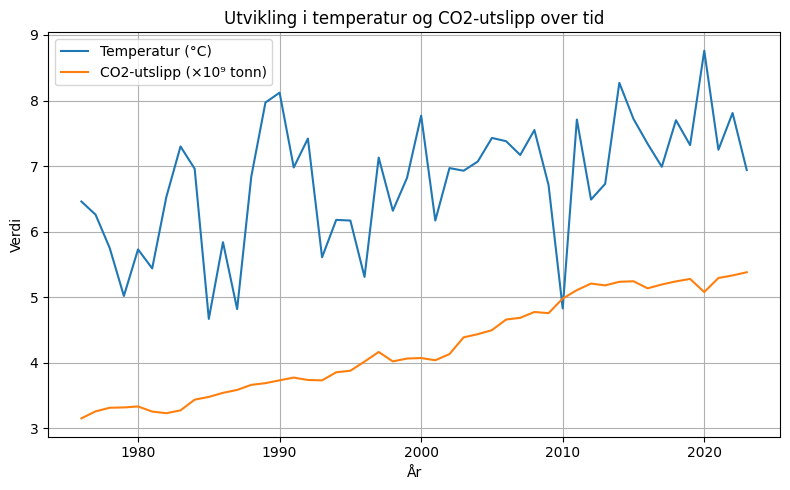

In [14]:
from prediksjon_visualisering import last_og_koble_data, plot_temp_vs_klima

df_merged = last_og_koble_data(
    "../data/temp_gloshaugen_historisk_renset_ 50.csv",
    "../data/klimagassutslipp_verden_renset.csv"
)
plot_temp_vs_klima(df_merged)

## Dataimportering og datainnlastning


Vi bruker df_merged.head() for å sjekke at DataFramen har blitt koblet sammen og lastet inn riktig.

In [15]:
df_merged.head()

,år,årsgjennomsnitt,gjennomsnitt,median
0,1976,6.46,3.153547e+10,3.153547e+10
1,1977,6.26,3.260304e+10,3.260304e+10
2,1978,5.75,3.315120e+10,3.315120e+10
3,1979,5.02,3.319875e+10,3.319875e+10
4,1980,5.73,3.334782e+10,3.334782e+10


### Visualisering med scatterplots

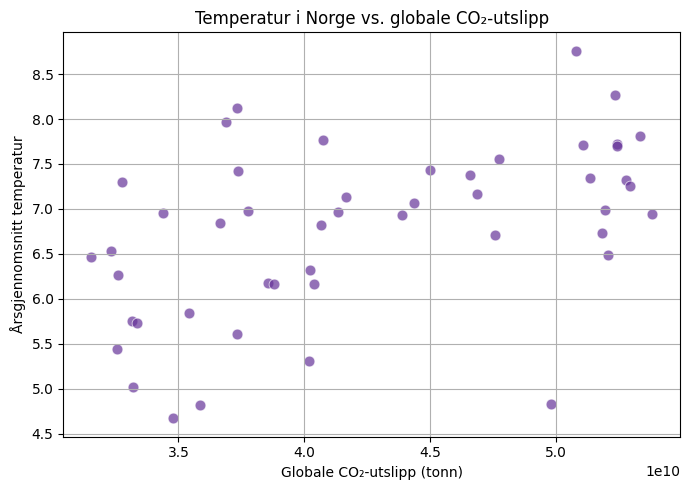

In [16]:
from prediksjon_visualisering import scatter_temp_vs_utslipp
scatter_temp_vs_utslipp(df_merged)


Hver prikk representerer et år i datasettet og for hvert år har de to verdier:
- Globale CO2-utslipp
- Årsgjennomsnittlig temperatur i Norge

**X-aksen:** Viser CO2-utslipp i 1e10 form. Skalaen går fra 3,3e10 (33 milliarder tonn) til 5,3e10. 

**Y-aksen:** Viser temperatur i celsius. Skalaen går automatisk fra 4,5 grader til 8,5. Dette bestemmes automatisk av min og maks i datasettet.

### Tolkning av scatterplot

Punktene er spredte og viser ikke til noen tydelig sammenheng mellom hverandre. Samtidig så kan vi se at når årstemperaturen og CO2-utslippet er lavt, så ligger punkene realtivt samlet, og når aksene øker, øker punktene i liten grad. Punktene starter samlet under 7,5 i årsgjennomsnitt (med unntak av noen outliers) og når CO2-utslippet øker avslutter punktene med kun én outlier under 6,5 grader.

Det globale utslippet virker til å ha økt over tid og i denne sammenhengen kan det se ut til at temperaturen øker i samsvar med denne. For å kunne være mer sikker er det nødvendig å utføre en regresjonsanalyse. 

### Visuell regresjonsmodell

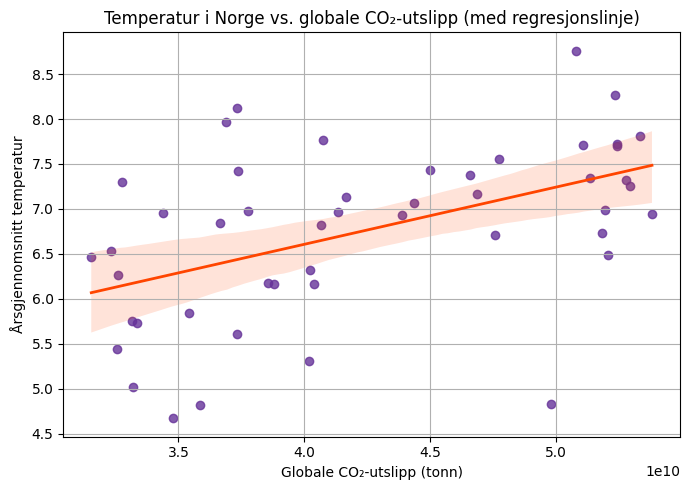

In [17]:
from prediksjon_visualisering import plot_regresjon_temp_vs_utslipp
plot_regresjon_temp_vs_utslipp(df_merged)

Her ser vi samme scatterplot som tidligere, bare inkludert en regresjonslinje. Denne linjen kan forklares som den beste tilpasningslinjen mellom aksene i plottet. Den prøver best å vise sammenhengen og utviklingen mellom aksene. 

Skyggeområdet rundt linjen er usikkerhetsintervallet til modellen. Den ligger på 95%. Dette betyr at modellen er 95% sikker på at temperaturer vil havne på den linjen.

### Tolkning av visuell regresjonsmodellen

Regresjonslinjen heller oppover. Dette tyder til at det finnes en positiv sammenheng mellom variablene: Når det globale CO2-utslippet øker, så øker årstemperatur-gjennomsnittet. Samtidig så ser vi at de fleste av plottene ikke ligger ved linjen, men eller ved skyggeintervallet eller rundt det. Dette viser at selv om sammenhenger er der, så er den ikke veldig sterk. Dette forklarer kort og enkelt at CO2-utslippet alene ikke er årsaken til temperaturøkningen i Norge.

Regresjonsmodellen kan likevell brukes som er verktøy for å gjøre grove predikasjoner og gi oss muligheten til å vurdere og utforske hvordan CO2-ekvivalent-utslippet kan påvirke den fremtidige temperaturen.


### Lineær regresjonsmodell
Ettersom at seaborn ikke gjør utrengingen automatisk, kan det være hjelpsomt å bruke en annen regresjonsmodell gjennom scikit-learn som gir oss muligheten til å trene opp en regresjonsmodell for så å ta den i bruk.

Det første vi gjør er å definere hvilken variabel som tilhører hvilken akse, forså å sjekke for manglende verdier i aksene.

In [18]:
X = df_merged[['gjennomsnitt']]
y = df_merged['årsgjennomsnitt']

print(X.isnull().sum())
print(y.isnull().sum())

gjennomsnitt    0
dtype: int64
0


Det er ingen manglende verdier.

Videre lager vi en ny regresjonsmodell som så printer ut i:
- (a) Hvor mye temperaturen endrer seg per tonn
- (b) Temperaturen ved utslipp = 0 i C02-utslipp
- MSE
- R^2 (R2)

In [19]:
from prediksjon import regresjonsmodell

model, r2, mse = regresjonsmodell(X, y)

print("Stigningstall (a):", model.coef_[0])
print("Konstantledd (b):", model.intercept_)
print("Mean Squared Error (MSE):", mse)
print("Forklaringsgrad (R2):", r2)


Stigningstall (a): 6.359966812715306e-11
Konstantledd (b): 4.062256392634006
Mean Squared Error (MSE): 0.6722834874052435
Forklaringsgrad (R2): 0.24657103593186158


**Stigningstall** ligger på 6.88e-11. Dette betyr at hver gang CO2-utlippet øker med 1 tonn, øker temperaturen med 6.88e-11 grader, altså 0.0000000000688 grader.

**Konstantledd** ligger på 3.84. Dette forteller oss at når CO2-utslippet er på 0, er temperaturen 3.84%.

**MSE** ligger på 0.71. Dette betyr at modellen i gjennomsnitt viker av med omretent 0.84 grader. Dette kan gi mye variasjon i svarene, men kan sees på som positivt med tanke på at miljøet varierer mye.

**R2** ligger på 0.266. Dette betyr at omtrent 26,6% av temperaturenforskjellen kan forklares av CO2-utslippet. Dette er ikke en sterk kobling, men en sterk nok en til at den kan brukes. Årsaken til at den er lav er på grunn av at det finnes andre årsaker til at temperaturen endres (klima, værfenomener ol.). CO2-ekvivalent-utslippet ser ut til å være 26,6% av de.

Nå er den lineære regresjonsmodellen trent opp og vi kan gjøre et forsøk på å predikere fremtiden.

## Prediktere fremtiden

La oss gjøre et forsøk på å beregne fremtidig temperatur. **Hva er temperaturen når de globale CO₂-utslippene er 60 milliarder tonn?**

In [20]:
fremtidig_utslipp = pd.DataFrame([[60_000_000_000]], columns=["gjennomsnitt"])
temperatur_prediksjon = model.predict(fremtidig_utslipp)

print("Prediktert temperatur:", temperatur_prediksjon[0])

Prediktert temperatur: 7.8782364802631895


Dersom de globale CO2-utslippene når 60 milliarder tonn, estimerer modellen at det årlige gjennomsnittet for Norge vil være 7.98 grader.

## Sammenheng mellom temperatur og luftforurensningsnivåer ved Elgeseter


c:\Users\johan\Documents\Mappe\src\statistikk.py:24: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[tidkolonne] = pd.to_datetime(df[tidkolonne], errors='coerce')


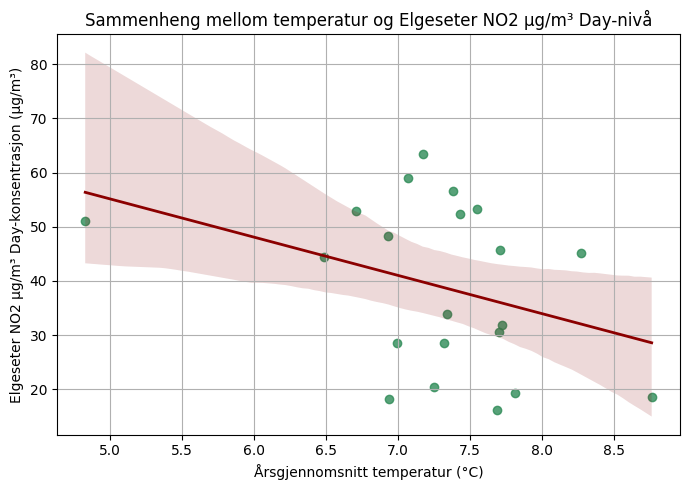

c:\Users\johan\Documents\Mappe\src\statistikk.py:24: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[tidkolonne] = pd.to_datetime(df[tidkolonne], errors='coerce')


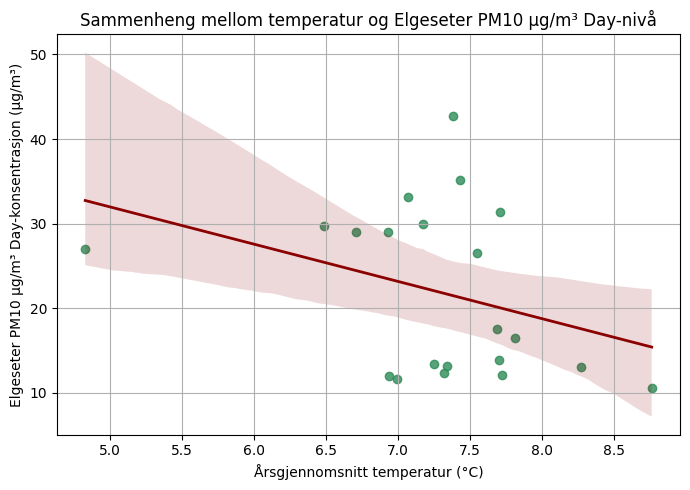

c:\Users\johan\Documents\Mappe\src\statistikk.py:24: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[tidkolonne] = pd.to_datetime(df[tidkolonne], errors='coerce')


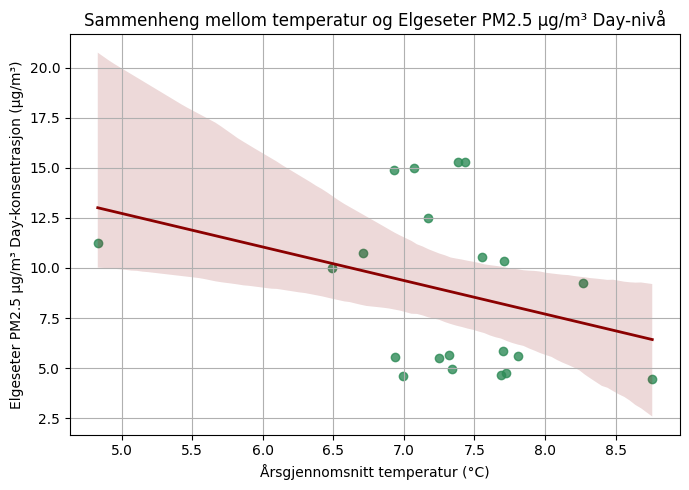

In [ ]:
from prediksjon_visualisering import plot_regresjon_luftkvalitet_vs_temp, last_og_koble_temp_luft

temp_fil = "../data/temp_gloshaugen_historisk_renset_ 50.csv"
luft_fil = "../data/gyldig_historisk_luftkvalitet.csv"

stoffer = [
    "Elgeseter NO2 µg/m³ Day",
    "Elgeseter PM10 µg/m³ Day",
    "Elgeseter PM2.5 µg/m³ Day"
]

for stoff in stoffer:
    df = last_og_koble_temp_luft(temp_fil, luft_fil, stoff)
    plot_regresjon_luftkvalitet_vs_temp(df, stoff=stoff)


#### Sammenheng mellom temperatur og luftforurensningsnivå (NO₂, PM10, PM2.5)
De tre grafene viser hvordan årsgjennomsnittstemperaturen henger sammen med nivåene av tre luftforurensningsstoffer (NO₂, PM10 og PM2.5) målt ved Elgeseter.

**NO₂ (Nitrogendioksid):** Figuren viser at høyere temperaturer gir lavere NO₂-konsentrasjoner. En mulig forklaring er at kaldere temperaturer fører til økt bruk av vedfyring, som øker utslippene. I tillegg reduseres luftsirkulasjonen om vinteren, noe som gjør at forurensningen blir værende nær bakken.

**PM10  og PM2.5:** Figurene viser også her at partikkelnivåene synker med høyere temperatur. Dette kan komme av at om vinteren er det mer svevestøv, f.eks. på grunn av bruk av piggdekk og veisalting. I tillegg blir den kalde luften (som er tyngre) liggende nær bakken, noe som reduserer spredningen av forurensningen.

Felles for alle stoffene er at det ser ut til at lavere temperaturer henger sammen med høyere forurensningsnivåer. Dette kan tyde på at kaldt klima forverrer luftkvaliteten. 